In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train_data_path = "~/aiffel/kaggle_kakr_housing/data/data/train.csv"
sub_data_path = "~/aiffel/kaggle_kakr_housing/data/data/test.csv"

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [54]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [55]:
y = data['price']

del data['price']

In [56]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

In [57]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.
### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

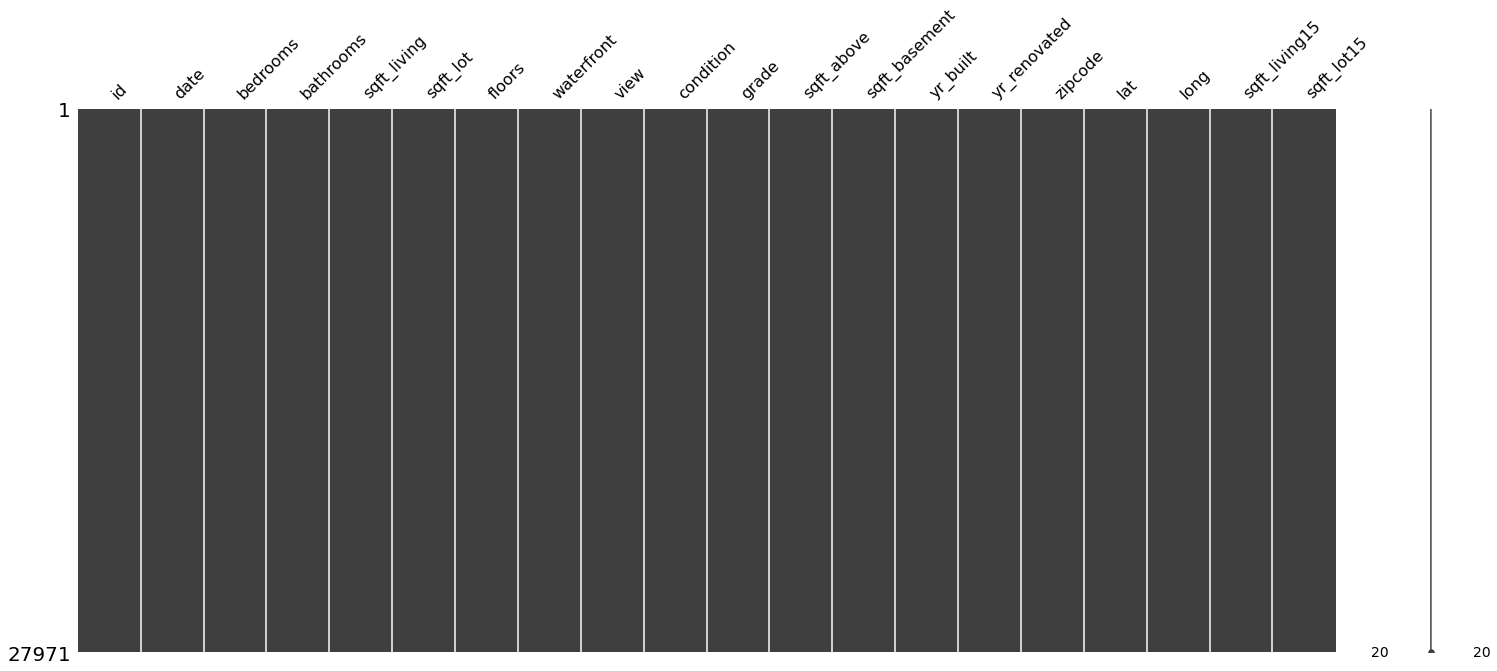

In [10]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [33]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


#### * 행별 결측치 알아보는 방법
1. id 컬럼이 결측치인지 확인

In [27]:
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


2. 결측치인 데이터만 뽑아내기

In [28]:
null_data = data.loc[null_check, 'id']
null_data.head()

Series([], Name: id, dtype: int64)

3. 결측치인 데이터의 개수를 세기

In [29]:
print(f'id: {len(null_data.values)}')

id: 0


한번에 작성하는 방법!!!

In [30]:
print('{} : {}'.format('id', len(data.loc[pd.isnull(data['id']), 'id'].values)))

id : 0


배운것을 바탕으로 모든 컬럼에 이것을 적용해보면

In [31]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [58]:
#나중 예측결과를 대비하여 sub_id 변수에 id 컬럼을 저장해두기
sub_id = data['id'][train_len:]
del data['id']


In [59]:
# date 컬럼은 apply 함수로 필요한 부분만 잘라주기
data['date'] = data['date'].apply(lambda x : str(x[:6]))

### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

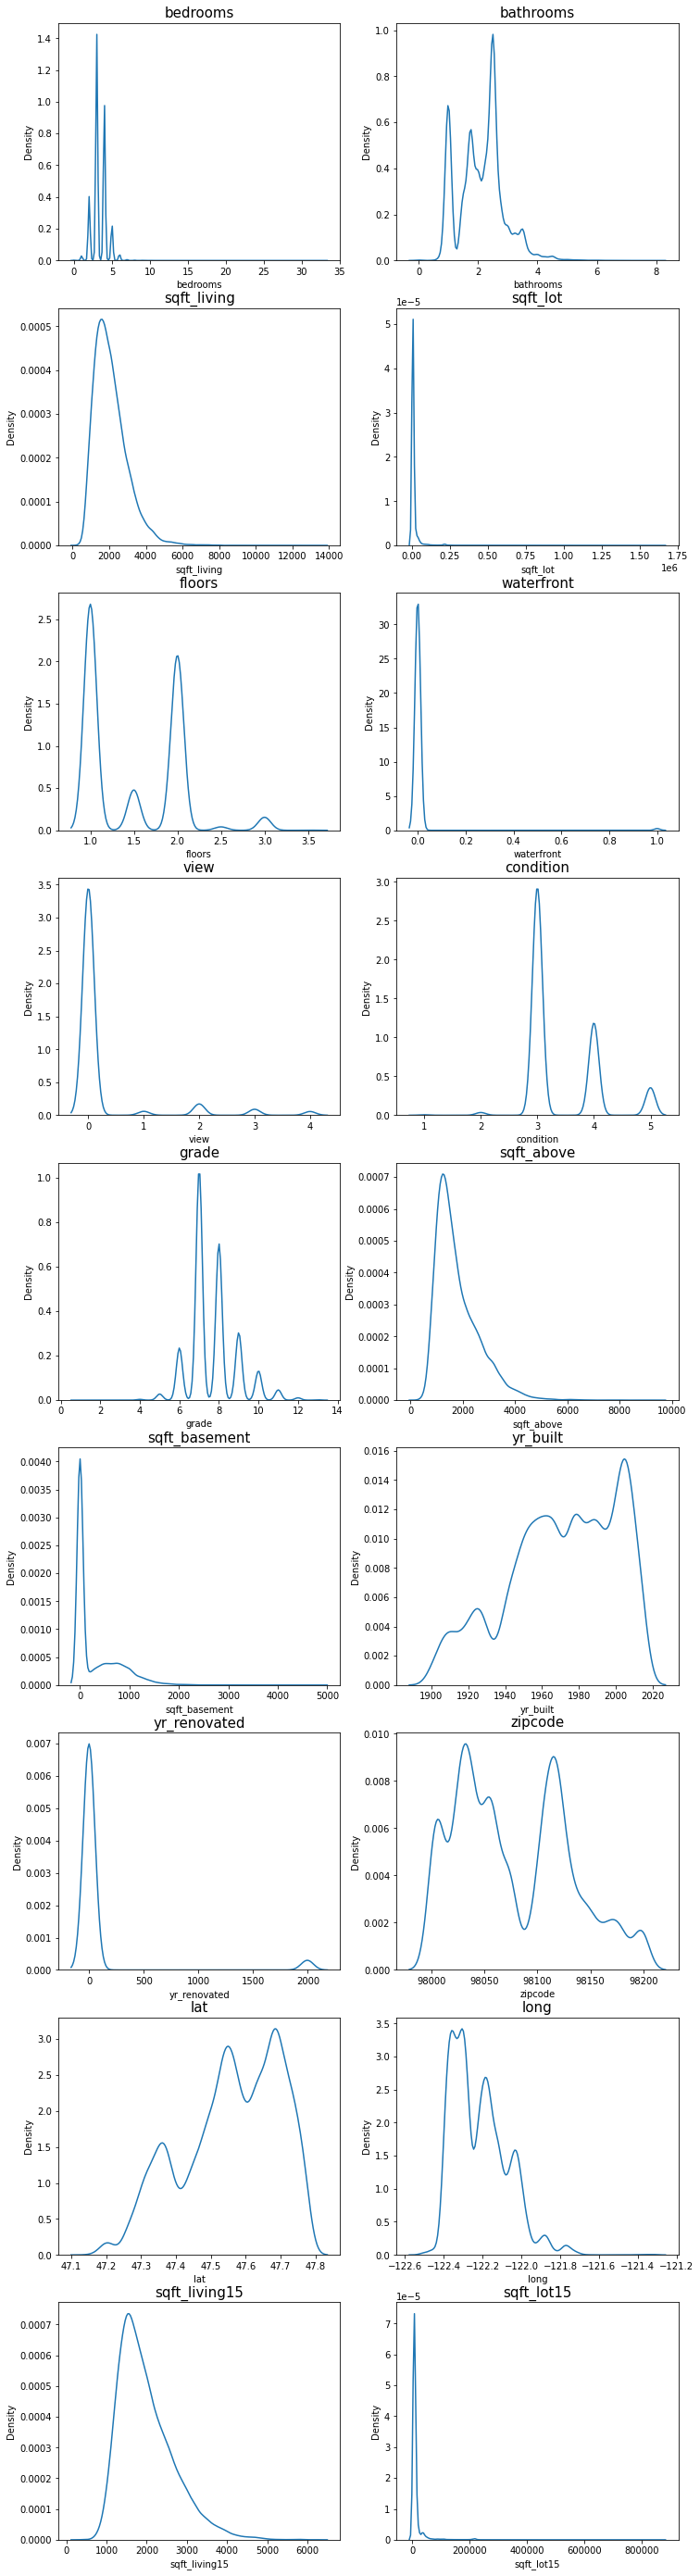

In [34]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [60]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

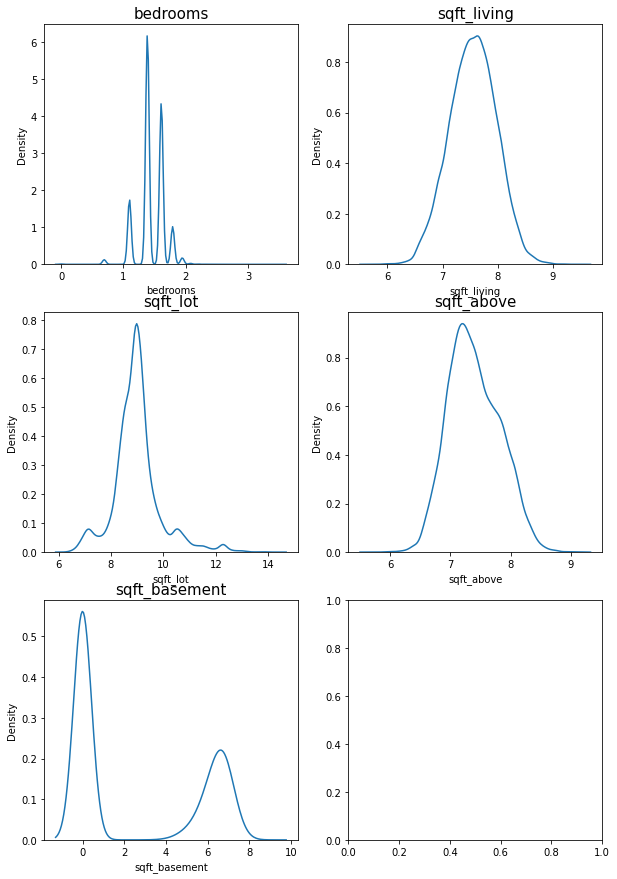

In [36]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        sns.kdeplot(data = data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1
        if count == 5:
            break


Why do we use log scaling?

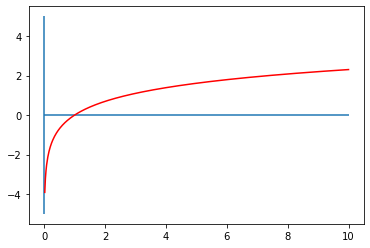

In [58]:
xx = np.linspace(0, 10, 500)
yy = np.log(xx)

plt.hlines(0, 0, 10)
plt.vlines(0, -5, 5)
plt.plot(xx, yy, c='r')
plt.show()

* $0 < x < 1$ 범위에서는 기울기가 매우 가파르다. x 구간은 (0,1)로 매우 짧은 반면, y의 구간은 ($-\infty$,0).
* 따라서 0에 가깝게 모여있는 값들이 x로 입력되면, 그 함수값인 y값들은 매우 큰 범위로 벌어지게 됨. -> 0에 가까운 값들이 조밀하게 모여있는 입력값을, 넓은 범위로 펼칠 수 있는 특징을 가짐.
* 반면, x값이 점점 커짐에 따라 로그 함수의 기울기는 급격히 작아짐. 이는 곧 큰 x값들에 대해서는 y값이 크게 차이나지 않게 된다는 뜻이고, 따라서 넓은 범위를 가지는 x를 비교적 작은 y값의 구간 내에 모이게 하는 특징을 가집니다.

위와 같은 특성 때문에 한 쪽으로 몰려있는 분포에 로그 변환을 취하게 되면 넓게 퍼질 수 있음.

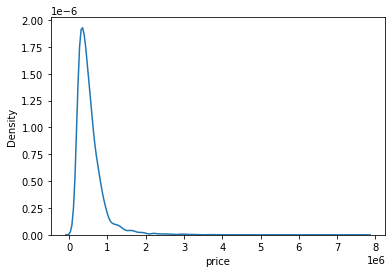

In [59]:
#ex)
sns.kdeplot(y)
plt.show()

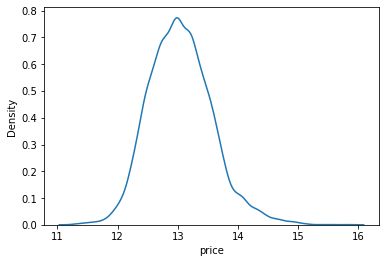

In [60]:
# ex) log scaling 
y_log_transformation = np.log1p(y)

sns.kdeplot(y_log_transformation)
plt.show()

어느정도 치우침이 줄어든 분포를 확인할 수 있습니다.

In [37]:
sub = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.<br>
Blending은 여러가지 모델을 섞어 사용해서 결과를 섞는 기법이다. <br>
블렌딩은 앙상블 기법이라고도 합니다.<br>
If you want to know more about ensemble learning, you can visit  [here](https://subinium.github.io/introduction-to-ensemble-1/#:~:text=%EC%95%99%EC%83%81%EB%B8%94(Ensemble)%20%ED%95%99%EC%8A%B5%EC%9D%80%20%EC%97%AC%EB%9F%AC,%EB%A5%BC%20%EA%B0%80%EC%A7%80%EA%B3%A0%20%EC%9D%B4%ED%95%B4%ED%95%98%EB%A9%B4%20%EC%A2%8B%EC%8A%B5%EB%8B%88%EB%8B%A4.)

In [62]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [65]:
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [66]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8597
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8819


### Make Submission

결정계수란?<br>
* 회귀모델이 주어진 자료에 얼마나 적합한지를 평가하는 지표<br>
* y의 변동량대비 모델 예측값의 변동량을 의미함<br>
* 0~1의 값을 가지며, 상관관계가 높을수록 1에 가까워짐<br>
* $r^2=0.3$인 경우 약 $30%$ 정도의 설명력을 가진다 라고 해석할 수 있음<br>
* sklearn의 $r^2$_score의 경우 데이터가 arbitrarily할 경우 음수가 나올수 있음<br>
* 음수가 나올경우 모두 일괄 평균으로 예측하는 것보다 모델의 성능이 떨어진다는 의미<br>
* 결정계수는 독립변수가 많아질 수록 값이 커지기때문에, 독립변수가 2개 이상일 경우 조정된 결정계수를 사용해야 함<br>

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [67]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [68]:
y_pred = AveragingBlending(models, x, y, sub)

In [69]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})

In [70]:
sub.to_csv('submission.csv', index=False)

In [71]:
result = pd.DataFrame({
    'id' : sub_id, 
    'price' : y_pred
})

result.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


## Parameter & HyperParameter

* Parameter: 모델이 학습을 하면서 점차 최적화되는, 그리고 최적화가 되어야하는 파라미터. ex) weight
* Hyperparameter: 모델이 학습을 하기위해서 사전에 사람이 직접 입력해 주는 파라미터. ex) # of epoch, learning rate, etc

In [61]:
data_dir = "~/aiffel/kaggle_kakr_housing/data/data/"
# hint : os.getenv를 사용하거나 직접 경로를 작성

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [62]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [63]:
# date coverting to int
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [64]:
y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [65]:
id_stored = train['id']
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [89]:
X = train

In [66]:
# test에도 똑같이 적용해야함
id_stored_test = test['id']
del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [67]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
test.head()

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [68]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

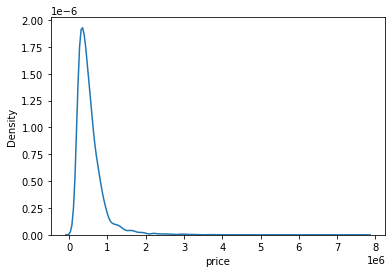

In [80]:
sns.kdeplot(y)
plt.show()

분포표가 너무 왼쪽으로 치우쳐져있다. 따라서 log-scaling을 통해 정규화를 시켜주는것이 좋을 것 같다.

In [69]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

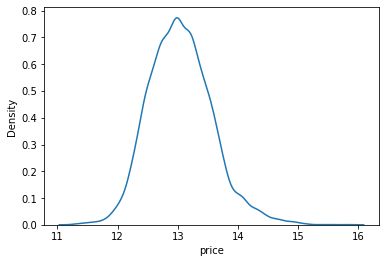

In [82]:
sns.kdeplot(y)
plt.show()

In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [84]:
#RMSE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 한 가지 주의해야 할 것은, y_test나 y_pred는 
# 위에서 np.log1p()로 변환이 된 값이기 때문에 
# 원래 데이터의 단위에 맞게 되돌리기 위해 
# np.expm1()을 추가해야 한다는 점입니다.

In [85]:
# XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

* 모델 파라미터 초기화나 데이터셋 구성에 사용되는 랜덤 시드값인 random_state 값을 특정 값으로 고정시키거나, 아니면 지정하지 않고 None으로 세팅할 수 있습니다. 
* random_state를 고정값으로 주면 모델과 데이터셋이 동일한 경우 머신러닝 학습결과도 항상 동일하게 재현됩니다. 
* 하지만 이 값을 지정하지 않고 None으로 남겨 두면 모델 내부에서 랜덤 시드값을 임의로 선택하기 때문에, 결과적으로 파라미터 초기화나 데이터셋 구성 양상이 달라져서 모델과 데이터셋이 동일하더라도 머신러닝 학습결과는 학습할 때마다 달라집니다.

이때, 어떤 시도가 모델 성능 향상에 긍정적이었는지 여부를 판단하기 위해서는 랜덤적 요소의 변화 때문에 생기는 불확실성을 제거해야 합니다. 따라서 아래와 같이 random_state 값을 특정 값으로 고정시킬 것입니다. 

In [87]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('我想休息')

我想休息


혹시 고정하지 않았을 때 어떤 상황이 벌어지는지 궁금하시다면 random_state 값을 None으로 남겨두고 실험을 반복해 보셔도 됩니다.

In [ ]:
# random_state=None # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
# gboost = GradientBoostingRegressor(random_state=random_state)
# xgboost = XGBRegressor(random_state=random_state)
# lightgbm = LGBMRegressor(random_state=random_state)
# rdforest = RandomForestRegressor(random_state=random_state)

# models = [gboost, xgboost, lightgbm, rdforest]

In [88]:
# 각 모델의 이름은 다음과 같이 클래스의 
# __name__ 속성에 접근해서 얻을 수 있습니다.
gboost.__class__.__name__

'GradientBoostingRegressor'

In [97]:
from sklearn.model_selection import train_test_split
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
    train_X, val_X, train_y, val_y = train_test_split(X,y, test_size = 0.2, random_state = random_state)

    # 모델 학습
    model.fit(train_X, train_y)
    
    # 예측
    pred_y = model.predict(val_X)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(val_y, pred_y)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

In [98]:
def get_scores(models, train, y):
    scores = {}
    for model in models:
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        train_X, val_X, train_y, val_y = train_test_split( train,y, test_size = 0.2, random_state = random_state)

        # 모델 학습
        model.fit(train_X, train_y)

        # 예측
        pred_y = model.predict(val_X)

        # 예측 결과의 rmse값 저장
        scores[model_name] = rmse(val_y, pred_y)

    return scores

get_scores(models, train, y)

{'GradientBoostingRegressor': 128360.19649691365,
 'XGBRegressor': 110318.66956616656,
 'LGBMRegressor': 111920.36735892233,
 'RandomForestRegressor': 125487.07102453562}

## Grid Search CV

Greed Search: 사람이 먼저 탐색할 하이퍼파라미터의 값들을 정해두고, 그 값들로 만들어질 수 있는 모든 조합을 탐색
* 특정 값에 대한 하이퍼 파라미터 조합을 모두 탐색하고자 할 때 유리
* 그리드 탐색에서는 사람이 정해둔 값들로 이루어지는 조합만 탐색하기 때문에 최적의 조합을 놓칠 수 있음
* 정해진 하이퍼 파라미터의 조합을 격자와 같이 탐색
* 따라서 탐색 공간이 매우 제한적
Random Search: 사람이 탐색할 하이퍼 파라미터의 공간만 정해두고, 그 안에서 랜덤으로 조합을 선택해서 탐색하는 방법
* 랜덤 탐색에서는 랜덤으로 탐색하기 때문에 최적의 조합을 찾을 수 있는 가능성이 열려있다. 
* 하지만 그 가능성 또한 랜덤성에 의존하기 때문에 언제나 최적을 찾는다는 보장은 없다.
* 랜덤으로 점을 찍어서 탐색
* 따라서 탐색하는 공간이 그리드 서치보다 훨씬 넓음

GridSearchCV 인자들
* param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
* scoring : 모델의 성능을 평가할 지표
* cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
* verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
* n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [99]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
} # 탐색할 xgboost관련 하이퍼 파라미터 넣어주기

model = LGBMRegressor(random_state=random_state) # 모델준비


In [100]:
#GridSearchCV를 이용해 grid_model 초기화하고 
#train 과 y 데이터로 모델을 
#간단히 학습히키면 param_grid 내의 
#모든 하이퍼 파라미터의 조합에 대해 실험이 완료됨

grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In param_grid, 2 of n_estimators and 2 of max depth. Therefore the total combination is 2*2 = 4
Also, crossvalidation works every 5 times. Thus totalling is 4*5 = 20 fits.

In [101]:
grid_model.cv_results_

{'mean_fit_time': array([0.5825747 , 0.70679059, 1.19843812, 1.79367352]),
 'std_fit_time': array([0.11996755, 0.0855381 , 0.2021135 , 0.18169554]),
 'mean_score_time': array([0.03971634, 0.0580132 , 0.07343731, 0.06589394]),
 'std_score_time': array([0.01240183, 0.01384911, 0.02422011, 0.02318945]),
 'param_max_depth': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 1, 'n_estimators': 50},
  {'max_depth': 1, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 50},
  {'max_depth': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.0756974 , -0.05555652, -0.02885847, -0.02665428]),
 'split1_test_score': array([-0.07666447, -0.057876  , -0.03041465, -0.02795896]),
 'split2_test_score': array([-0.07354904

params과 mean_test_score만 빼내어보자

In [102]:
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']
print(params)
print(score)

[{'max_depth': 1, 'n_estimators': 50}, {'max_depth': 1, 'n_estimators': 100}, {'max_depth': 10, 'n_estimators': 50}, {'max_depth': 10, 'n_estimators': 100}]
[-0.07339447 -0.05502043 -0.02917734 -0.02702714]


In [104]:
# CV 파일로 만들기
results = pd.DataFrame(params)
results['score'] = score

results.head()

,max_depth,n_estimators,score
0,1,50,-0.073394
1,1,100,-0.055020
2,10,50,-0.029177
3,10,100,-0.027027


scoring이 음수인 이유는 GridSearchCV에서 모델을 초기화할때 neg_mean_squared_error을 입력했기때문
GridSearchCV를 사용할 때에는 이 외에도 다양한 점수 체계(scoring)를 사용할 수 있다. [그 정보는 여기에!](https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter)<br>
각 점수는 Classification, Clustering, Regression으로 분류해놓고있다.

In [105]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results

,max_depth,n_estimators,score,RMSE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


price의 분포가 한쪽으로 치우쳐져있어 log scaling을 했었다. 그 후 RMSE값을 계산하기 위한 함수에서는 내부에서 np.expm1함수를 활용해 다시 원래대로 복원한 후 RMSE값을 계산했었다. 하지만 그리드 탐색을 하면서는 log scaling되어있는 상태의 데이터에서 손실함수값을 계산했다. 따라서 위의 RMSE값은 RMSEL의 값이다. 따라서 위의 RMSE의 값을 RMSLE로 바꿔주자.

In [106]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.073394,0.270914
1,1,100,-0.055020,0.234564
2,10,50,-0.029177,0.170814
3,10,100,-0.027027,0.164399


In [107]:
# RMSLE가 낮은 순서대로 정렬해보자
results.sort_values(by = 'RMSLE')

,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [108]:
# 위의 과정을 class 함수로 만들어보자
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [109]:
# myGridSearch를 사용해 그리드 탐색해보기
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [110]:
# 가장 좋은 조합은 max_depth = 10, n_estimators = 100일때이다.
# 이 조합으로 모델을 학습을 해서 예측값을 submission파일로 만들어보자.
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [111]:
# log scaling을 원래대로 되돌려놓기!
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [115]:
submission_path = "~/aiffel/kaggle_kakr_housing/data/data/sample_submission.csv"

submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


[CV] END .......................max_depth=1, n_estimators=50; total time=   0.4s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.7s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.4s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.5s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.9s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.5s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.5s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.7s
[CV] END ......................max_depth=10, n_estimators=50; total time=   1.3s
[CV] END ...................

In [116]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [117]:
data_dir = "~/aiffel/kaggle_kakr_housing/data/data/"

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.164399')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

~/aiffel/kaggle_kakr_housing/data/data//submission_lgbm_RMSLE_0.164399.csv


In [118]:
submission 저장하는 함수
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '~/aiffel/kaggle_kakr_housing/data/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [119]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.164399')

~/aiffel/kaggle_kakr_housing/data/data/submission_lgbm_RMSLE_0.164399.csv saved!


# Let's Start Project
* Focus on HyperParameter

* You can try:
    * 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
    * LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
    * 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
    * Baseline 커널에서 활용했던 블렌딩 방법 활용하기

### Data Preprocess
하고싶었으나 시간을 너무 잡아먹는것같아 따로 시간을 내서 해야겠다.
<br>
따라서 위의 train, test data를 사용하고자 한다.

In [14]:
# data: train data, sub : test data
# 데이터 확인
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<AxesSubplot:>

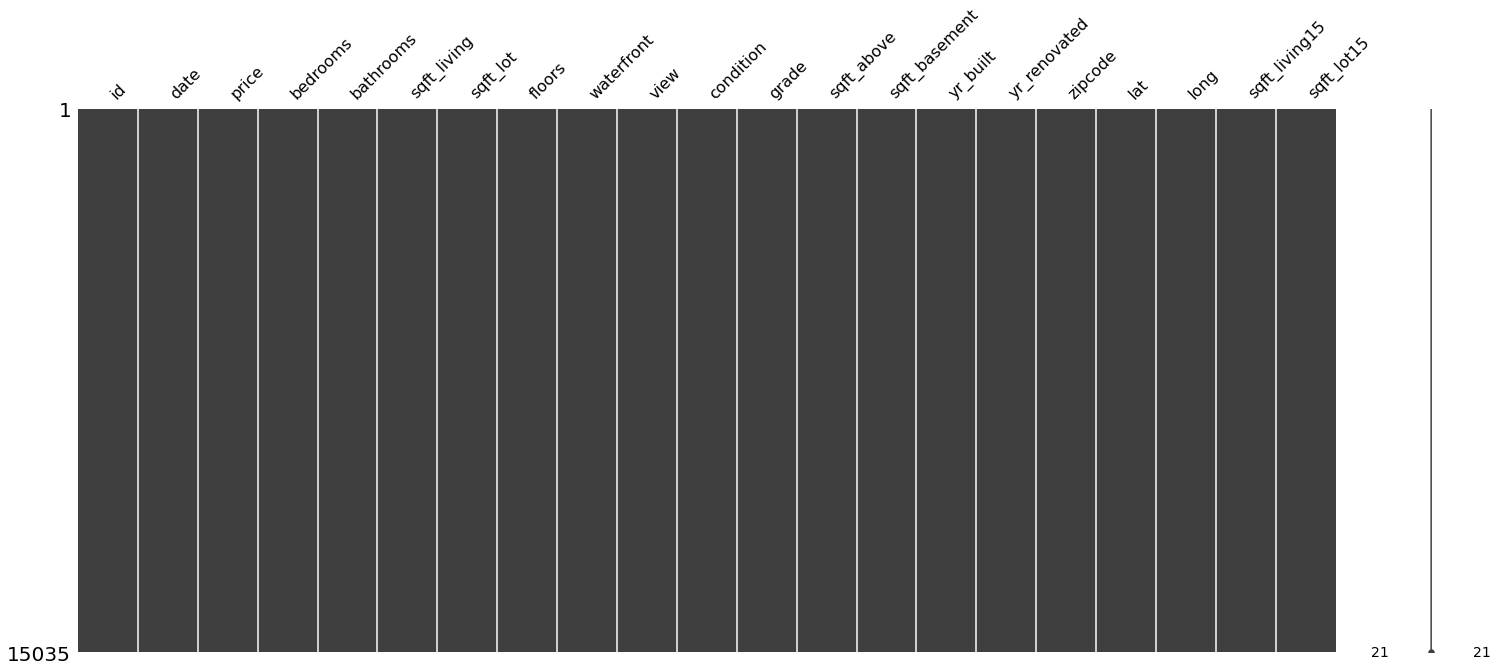

In [15]:
# 결측치 확인
msno.matrix(data)

In [18]:
data['date'] = data['date'].apply(lambda i: i[:6]).astype(int)
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [19]:
list(data.columns.values)

['id',
 'date',
 'price',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [20]:
# HEAT MAP
pricing_corr = data[['price', 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']]
corr = pricing_corr.corr()
corr

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.323672,0.525479,0.702899,0.096793,0.262588,0.265738,0.400806,0.039740,0.667211,0.608577,0.322218,0.047290,0.140808,-0.051498,0.301604,0.023547,0.586419,0.086384
bedrooms,0.323672,1.000000,0.530548,0.596974,0.033475,0.189532,-0.004819,0.085703,0.034885,0.375286,0.494867,0.315183,0.158799,0.022729,-0.162081,-0.011190,0.135802,0.407394,0.027242
bathrooms,0.525479,0.530548,1.000000,0.755853,0.089308,0.508649,0.075452,0.187488,-0.125907,0.666278,0.688255,0.282642,0.503964,0.065423,-0.207500,0.018110,0.227669,0.573541,0.088120
sqft_living,0.702899,0.596974,0.755853,1.000000,0.176500,0.363193,0.108137,0.282821,-0.054213,0.762543,0.878736,0.434017,0.315927,0.064893,-0.200745,0.051609,0.245429,0.760271,0.184176
sqft_lot,0.096793,0.033475,0.089308,0.176500,1.000000,0.001535,0.025584,0.080441,-0.002099,0.119906,0.186242,0.017818,0.058686,-0.001451,-0.127709,-0.082234,0.227451,0.147562,0.728458
floors,0.262588,0.189532,0.508649,0.363193,0.001535,1.000000,0.031159,0.034511,-0.261016,0.462598,0.529476,-0.239350,0.490436,0.009752,-0.059107,0.049004,0.126983,0.287125,-0.010287
waterfront,0.265738,-0.004819,0.075452,0.108137,0.025584,0.031159,1.000000,0.389669,0.011613,0.088061,0.081968,0.071576,-0.026523,0.104168,0.028632,-0.014772,-0.037922,0.091810,0.028255
view,0.400806,0.085703,0.187488,0.282821,0.080441,0.034511,0.389669,1.000000,0.045255,0.247924,0.172693,0.265880,-0.061670,0.107605,0.089247,0.005285,-0.073151,0.278267,0.076501
condition,0.039740,0.034885,-0.125907,-0.054213,-0.002099,-0.261016,0.011613,0.045255,1.000000,-0.143599,-0.152856,0.175064,-0.366590,-0.062342,0.001106,-0.015974,-0.110742,-0.091407,-0.003873
grade,0.667211,0.375286,0.666278,0.762543,0.119906,0.462598,0.088061,0.247924,-0.143599,1.000000,0.759240,0.162657,0.440608,0.030155,-0.186541,0.112319,0.202130,0.715321,0.119734


<AxesSubplot:title={'center':'Heatmap of House Pricing'}>

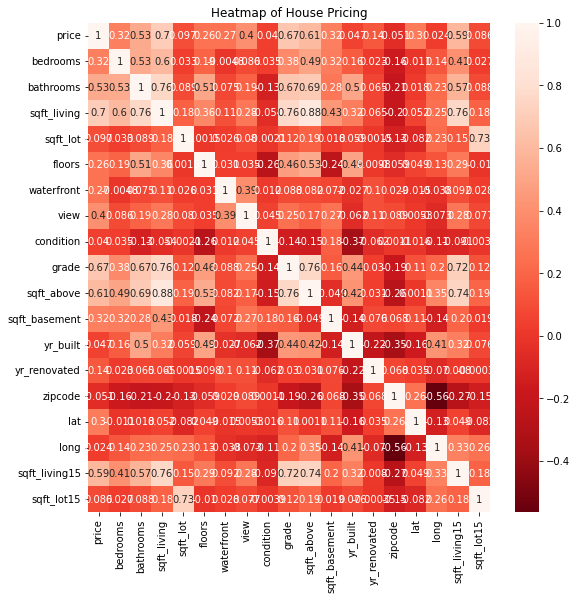

In [21]:
plt.figure(figsize=(9,9))
plt.title("Heatmap of House Pricing")
sns.heatmap(corr, annot = True, cmap = 'Reds_r')

## MODELING

In [49]:
import xgboost
import lightgbm
import missingno
import sklearn
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
print(xgboost.__version__)
print(lightgbm.__version__)
print(missingno.__version__)
print(sklearn.__version__)

1.4.2
3.3.0
0.5.0
1.0


In [50]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

# models = [gboost, xgboost, lightgbm, rdforest]

* lightGBM/ XGBoost
-  learning rate/ eta: 0.05 ~ 0.1
- num_iterations/ nrounds: 
    * lgb default: 100 -> change it to 1000 if you set it  higher, it will be overfitting. 
    * If you set early_stopping, you can set it 10000 at best but it won't change that much.
- max_depth: if you have many features, set it higher. When you set parameter, you need set it first. (default is -1)
- boosting method: boosting/ booster
    * lightGBM: rf/ gbdt(default)/dart(deeplearning dropout) - better predicition in general, not always./goss (using sampling) - computing speed reduce but prediction won't be good.
- metric/loss: 
    * cross_entropy(binary)
    * cross_entropy(multiclass)
    * MSE (regression_l2)
    * MAE (regression_l1)
    * MAPE (MAPE)
    * Log Transformation(poisson)
    * Quantile (quantile)
    * huber (Huber loss, MAE approx)
    * fair (Fair loss, MAE approx)
    * gamma (Residual Deviance)
    * lambdarank
    * tweedie


In [51]:
lightGBM_parameters = {'learning_rate': [0.01,0.05,0.1,0.5],
              'max_depth': [-1, 1, 5, 10],
             'num_iterations': [100,500,1000],
            'boosting': ['gbdt', 'dart', 'goss']}
boosting_parameters = {'eta': [0.01,0.05,0.1,0.5],
              'max_depth': [-1, 1, 5, 10],
             'nrounds': [100,500,1000],
            'booster': ['gbdt', 'dart', 'goss']}

In [52]:
def get_scores(model,train, y):
    scores = {}
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리
    # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
    train_X, val_X, train_y, val_y = train_test_split( train,y, test_size = 0.2, random_state = random_state)

    # 모델 학습
    model.fit(train_X, train_y)

    # 예측
    pred_y = model.predict(val_X)

    # 예측 결과의 rmse값 저장
    scores[model_name] = rmse(val_y, pred_y)

    return scores

In [73]:
#RMSE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

# 한 가지 주의해야 할 것은, y_test나 y_pred는 
# 위에서 np.log1p()로 변환이 된 값이기 때문에 
# 원래 데이터의 단위에 맞게 되돌리기 위해 
# np.expm1()을 추가해야 한다는 점입니다.

In [75]:
from sklearn.model_selection import train_test_split
lightgbm_scores= []
for a in lightGBM_parameters['learning_rate']:
    for b in lightGBM_parameters['max_depth']:
        for c in lightGBM_parameters['num_iterations']:
            for d in lightGBM_parameters['boosting']:
                print(f'lr:{a}, m_d:{b}, iter:{c}, boosting:{d}')
                lightgbm = LGBMRegressor(random_state=random_state, 
                                         learning_rate = a, 
                                         max_depth = b, 
                                         num_iterations = c, 
                                         boosting = d)
                lightgbm_scores.append(get_scores(lightgbm, train, y))
                



lr:0.01, m_d:-1, iter:100, boosting:gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
lr:0.01, m_d:-1, iter:100, boosting:dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
lr:0.01, m_d:-1, iter:100, boosting:goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
lr:0.01, m_d:-1, iter:500, boosting:gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
lr:0.01, m_d:-1, iter:500, boosting:dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
lr:0.01, m_d:-1, iter:500, boosting:goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
lr:0.01, m_d:-1, iter:1000, boosting:gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt wi

lr:0.05, m_d:5, iter:100, boosting:goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
lr:0.05, m_d:5, iter:500, boosting:gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
lr:0.05, m_d:5, iter:500, boosting:dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
lr:0.05, m_d:5, iter:500, boosting:goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
lr:0.05, m_d:5, iter:1000, boosting:gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
lr:0.05, m_d:5, iter:1000, boosting:dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
lr:0.05, m_d:5, iter:1000, boosting:goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be

lr:0.5, m_d:-1, iter:500, boosting:dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
lr:0.5, m_d:-1, iter:500, boosting:goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
lr:0.5, m_d:-1, iter:1000, boosting:gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
lr:0.5, m_d:-1, iter:1000, boosting:dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be ignored. Current value: boosting=dart
lr:0.5, m_d:-1, iter:1000, boosting:goss
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
lr:0.5, m_d:1, iter:100, boosting:gbdt
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
lr:0.5, m_d:1, iter:100, boosting:dart
[LightGBM] [Warning] boosting is set=dart, boosting_type=gbdt will be i

In [ ]:
xboosting_scores =[]
for a in boosting_parameters['eta']:
    for b in boosting_parameters['max_depth']:
        for c in boosting_parameters['nrounds']:
            for d in boosting_parameters['booster']:
                xgboost = XGBRegressor(random_state=random_state, 
                                         eta = a, 
                                         max_depth = b, 
                                         nrounds = c, 
                                         booster = d)
                xboosting_scores.append(get_scores(lightgbm, train, y))                
